# Transformer Prediction Model Diarrhoea Version 3
Date: 28/11/2022
Description: Transformer
Data: new data

In [1]:
# Install packages
!pip install -U scikit-learn
!pip install ftfy
# !pip install xlsxwriter 
# !pip install xlwt


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports
import tensorflow as tf 
# from google.colab import drive
import os

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

import traceback
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.rcParams['figure.figsize'] = [7, 3]

import math

# Input path

In [3]:
# Attach Google Drive for reading and saving files
# drive.mount('/content/drive')
prj_path = '/home/mlworker/Quang/HealthCare/Source_14012023_v4/'
prj_path_opt=  prj_path + '/optimize_hyperparam/opt_results/'
data_path = prj_path + '/data/new_data/DH/squeezed/'

# result path
path =  prj_path + '/results/'
path_metrix =  prj_path + '/results/metrix/'

path_all_mix_cnn= prj_path + '/results/all_mix_data/cnn/'
path_all_mix_lstm= prj_path + '/results/all_mix_data/lstm/'
path_all_mix_lstm_att= prj_path + 'results/all_mix_data/lstm_att/'
path_all_mix_tf= prj_path + 'results/all_mix_data/transformer/'

os.chdir(prj_path)

# Class Train and Support Functions for Preprocess

---



In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

In [5]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 24 tháng = 2 năm
        self.test_size = 24
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng 3 tháng
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.epochs = 300

args = Configuration()

# Pre-processing Functions

In [6]:
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']

def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(data_path+'squeezed_'+city+'.xlsx')  
    # Đoạn này rất quan trọng. Optimize không được đụng vào 36 tháng (2015-2017) để dự báo. 
    # Lúc train và predict thì ok. Lấy từ 1997 -2017. 
    # Function split data sẽ lấy 3 năm cuối làm test data theo config     
    city_result = city_result.loc[city_result['year_month'] < '2016-1-1'] 
    cities_data[city] = city_result
  return cities_data

dict_full_data = get_dict_all_city_data()

In [7]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name):
    """Returns Diarrhoea rate and climate data only""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                                        'Influenza_rates','Dengue_fever_rates',
                                                        'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                                        'population_male','population_female','population_urban',
                                                        'population_countryside','area','population_density',
                                                        'population_average','birth_rate','urban_water_usage_rate',
                                                        'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data


def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [8]:
dict_full_data['Tiền Giang']
city_TienGiang = get_city_data('Tiền Giang')

In [9]:
def split_data(data, look_back ):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]
    print('lookback', look_back)
    test = data[-args.test_size - look_back: ]
    return train, test

In [10]:
def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [11]:
def select_feature(train, specific_data):
    """Selects args.n_features top features using RFE"""
    train_X, train_y = to_supervised(train, d_in=1, d_out=1)
    train_X, train_y = np.squeeze(train_X), np.squeeze(train_y)
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=args.seed), n_features_to_select=args.n_features)
    fit = rfe.fit(train_X, train_y)
    important_features = list()
    print("Important Feature:")
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            important_features.append(i)
            print(specific_data.columns[i])
    return np.array(important_features)

In [12]:
def get_data(train_np, test_np, batch_size, specific_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """
    important_features = select_feature(train_np, specific_data)

    train_X, train_y = to_supervised(train_np, features_list=important_features)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

In [13]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

In [14]:
# Transformer Model
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=3, n_feature=3, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(n_feature, d_model)
        for pos in range(n_feature):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                if i + 1 < d_model:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.d_model)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input, n_head, hidden_size, n_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.pe = PositionalEncoder(dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_head, args.n_predicted_month)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
        self.loss_fn = nn.MSELoss()
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

In [15]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, city, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type    
        self.city = city    
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout, city)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout, city):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type.lower() == 'transformers':
            model = TransformerModel(d_input=args.look_back, n_head=3, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)   
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None



    # Lưu model vào trong thư mục models
    def save_model_to(self, path = '', city =''):       
        torch.save(self.model, path)

    def load_model_to(self, path = ''):       
        return torch.load(path)

    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None, y_scaler =None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data)
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )

            

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            print('City: '+self.city+'  _algo:'+self.model_type+'  -RMSE: '+str(rmse))          
            if plot==True:
              plt.grid(True)
              plt.plot(y_predicted, label='predicted')
              plt.plot(y_true, label='actual')
              plt.title(f"k-steps = {k_steps} - city: "+self.city+'  _algo:'+self.model_type+'  -RMSE: '+str(rmse))
              plt.legend()
              plt.show()

              plt.show()
            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

In [16]:
def convert_str_num_filter_array(str_filter = ''):  
  arr_filter = str_filter.split(',')  
  int_arr_filter= [int(x) for x in arr_filter]
  return int_arr_filter

# Get Optimized HyperParam

In [17]:

# prj_path_opt= '/content/drive/MyDrive/HealthCare/Source/optimize_hyperparam/opt_results/'
# opt_param_cnn = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_cnn.xlsx', index_col = 'City')
# opt_param_lstm = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm.xlsx', index_col = 'City')
# opt_param_lstm_att = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm_att.xlsx', index_col = 'City')
opt_param_transformer = pd.read_excel(prj_path_opt+'/transformer_30012023_v4/diarrhoea_opt_hyperparam_transformer.xlsx', index_col = 'City')
# opt_param_transformer = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_transformer.xlsx', index_col = 'City')

def get_opt_param_by_name(algo = 'transformer', city = None):
  # if algo == 'cnn':
  #   city_param = opt_param_cnn.loc[city]
  #   #load  param
  #   n_layers = ''
  #   hidden_size = ''
  #   num_filters = convert_str_num_filter_array(city_param['Num. filters'])
  #   dropout = float(city_param['Dropout rate'])
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm':
  #   city_param = opt_param_lstm.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm_attention':
  #   city_param = opt_param_lstm_att.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  if algo == 'transformer':
    city_param = opt_param_transformer.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hidden Size'])
    num_filters = ''
    dropout = float(city_param['Dropout rate'])
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  return n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window


In [18]:
# Manual Check param before train
n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window= get_opt_param_by_name(algo='transformer', city='Cao Bằng')
lookback_window,epoch, hidden_size, n_layers,learning_rate, num_filters, dropout

(3, 410, 15, 5, 0.004862539219123058, '', 0.4366102806654315)

# Mix Result và Lưu vào folder tương ứng theo từng algo

In [19]:
def mix_results(city, algo, specific_data, y_pred_test, y_pred_train, lookback_window, iteration, rmse, mae, mape):
    new_cols = ["City","Algorithm","Run Seq","Observed","Train Prediction","Test Prediction","rmse","mae","mape"]
    mix_train_test_result = pd.DataFrame()
    mix_train_test_result['Observed']= specific_data['Diarrhoea_rates'] #default lenght 239
    mix_train_test_result = mix_train_test_result.reset_index(drop=True)  
    mix_train_test_result['City'] = city
    mix_train_test_result['Algorithm'] = algo
    mix_train_test_result['Run Seq'] = iteration 
    mix_train_test_result['Train Prediction'] = None
    mix_train_test_result['Test Prediction'] = None
    mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
    mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
    mix_train_test_result['rmse'] = rmse
    mix_train_test_result['mae'] = rmse
    mix_train_test_result['mape'] = rmse
    mix_train_test_result= mix_train_test_result.reindex(columns=new_cols)
    return mix_train_test_result

In [20]:
def save_results(all_mix_train_test_result, algo,city):
  if algo == 'cnn':  
    all_mix_train_test_result.to_excel(path_all_mix_cnn+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm':
    all_mix_train_test_result.to_excel(path_all_mix_lstm+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm_att':
    all_mix_train_test_result.to_excel(path_all_mix_lstm_att+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'tf':
    all_mix_train_test_result.to_excel(path_all_mix_tf+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)


# Transformer train and run

<ipython-input-7-ba9a18586afe>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])


lookback 3
Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/390 - train_loss: 0.9159 - test_loss: 0.735184
Epoch: 97/390 - train_loss: 0.1206 - test_loss: 0.059474
Epoch: 194/390 - train_loss: 0.1197 - test_loss: 0.059291
Epoch: 291/390 - train_loss: 0.1198 - test_loss: 0.054911
Epoch: 388/390 - train_loss: 0.1191 - test_loss: 0.056468
Epoch: 389/390 - train_loss: 0.1462 - test_loss: 0.057266
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 27.06531508674896


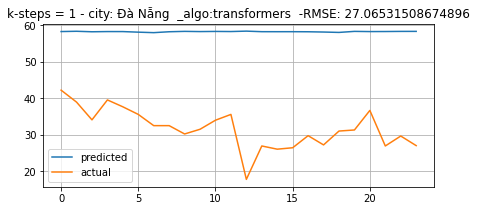

City: Đà Nẵng  _algo:transformers  -RMSE: 24.816125144503918


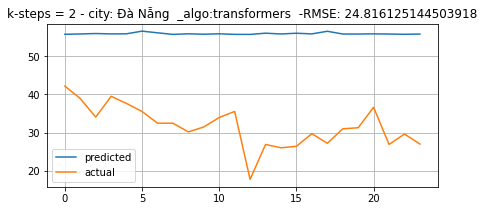

City: Đà Nẵng  _algo:transformers  -RMSE: 23.16676852253339


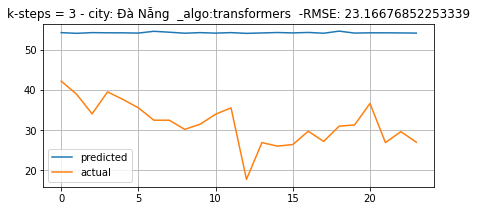

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 105.80395497394618


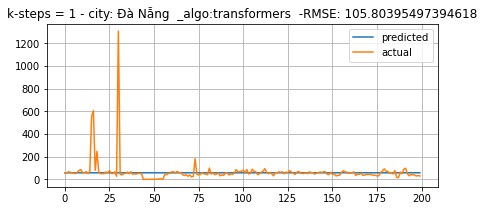

City: Đà Nẵng  _algo:transformers  -RMSE: 105.97906988358443


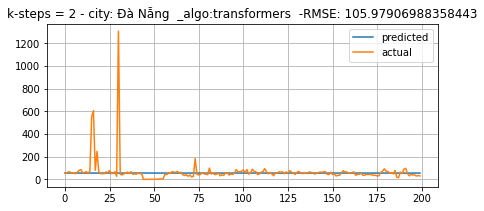

City: Đà Nẵng  _algo:transformers  -RMSE: 106.13077841630128


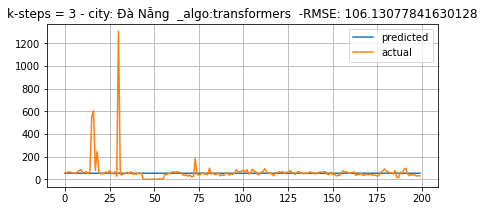

lookback 3


<ipython-input-19-76df619bec93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-76df619bec93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d3ac46aae96e>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/390 - train_loss: 0.9538 - test_loss: 0.697526
Epoch: 97/390 - train_loss: 0.1523 - test_loss: 0.064180
Epoch: 194/390 - train_loss: 0.1475 - test_loss: 0.058500
Epoch: 291/390 - train_loss: 0.1202 - test_loss: 0.055949
Epoch: 388/390 - train_loss: 0.1199 - test_loss: 0.058691
Epoch: 389/390 - train_loss: 0.1203 - test_loss: 0.055468
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 22.256691493057424


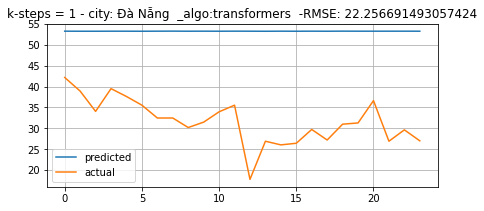

City: Đà Nẵng  _algo:transformers  -RMSE: 20.48481730148063


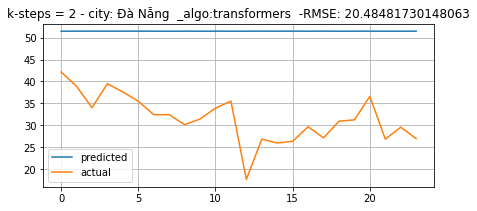

City: Đà Nẵng  _algo:transformers  -RMSE: 10.405853782414036


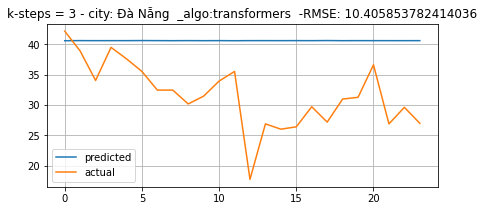

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 106.22433769325097


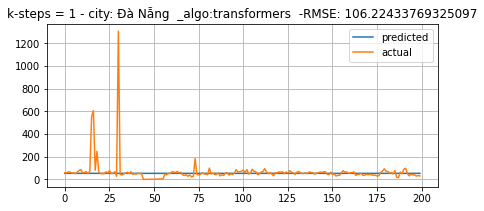

City: Đà Nẵng  _algo:transformers  -RMSE: 106.4365665135862


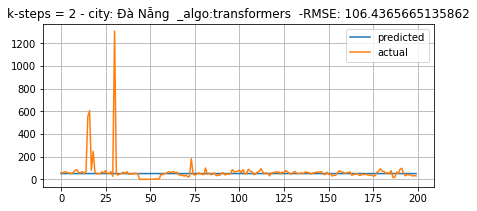

City: Đà Nẵng  _algo:transformers  -RMSE: 108.3233813143212


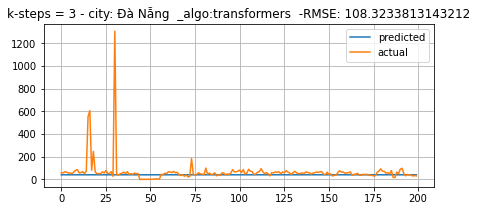

lookback 3


<ipython-input-19-76df619bec93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-76df619bec93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d3ac46aae96e>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/390 - train_loss: 1.1731 - test_loss: 0.798472
Epoch: 97/390 - train_loss: 0.1213 - test_loss: 0.061735
Epoch: 194/390 - train_loss: 0.1450 - test_loss: 0.059326
Epoch: 291/390 - train_loss: 0.1193 - test_loss: 0.054238
Epoch: 388/390 - train_loss: 0.1199 - test_loss: 0.056372
Epoch: 389/390 - train_loss: 0.1193 - test_loss: 0.056260
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 11.755781511458768


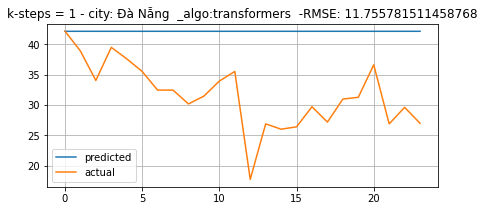

City: Đà Nẵng  _algo:transformers  -RMSE: 12.83141160311599


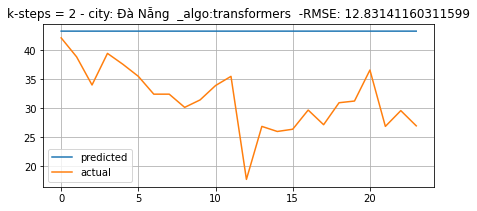

City: Đà Nẵng  _algo:transformers  -RMSE: 22.271081727823283


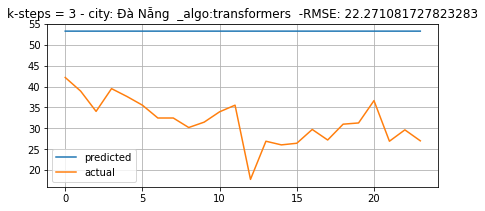

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 107.9905437190502


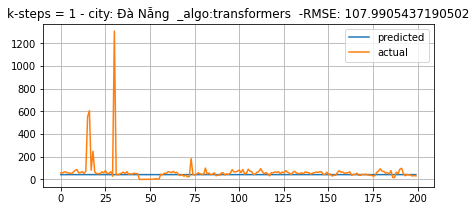

City: Đà Nẵng  _algo:transformers  -RMSE: 107.74748343031443


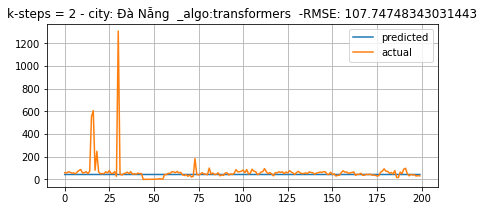

City: Đà Nẵng  _algo:transformers  -RMSE: 106.22248340812413


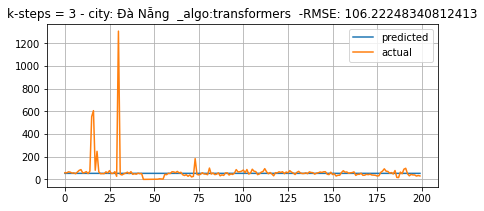

lookback 3


<ipython-input-19-76df619bec93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-76df619bec93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d3ac46aae96e>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/390 - train_loss: 0.7280 - test_loss: 0.658400
Epoch: 97/390 - train_loss: 0.1507 - test_loss: 0.059727
Epoch: 194/390 - train_loss: 0.1466 - test_loss: 0.057600
Epoch: 291/390 - train_loss: 0.1282 - test_loss: 0.057899
Epoch: 388/390 - train_loss: 0.1186 - test_loss: 0.057380
Epoch: 389/390 - train_loss: 0.1198 - test_loss: 0.058736
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 31.972980205256892


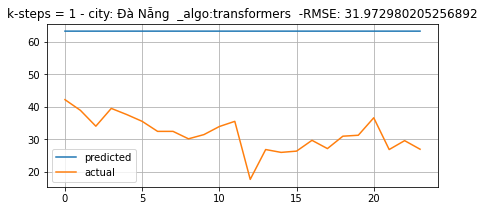

City: Đà Nẵng  _algo:transformers  -RMSE: 28.02532237322905


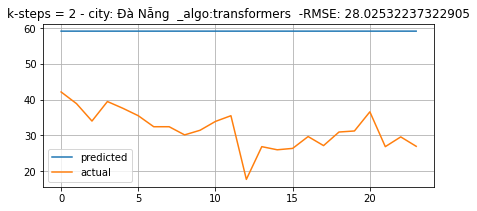

City: Đà Nẵng  _algo:transformers  -RMSE: 25.70947869453557


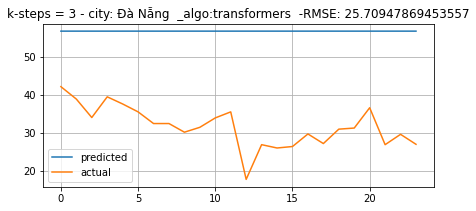

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 105.61738065235672


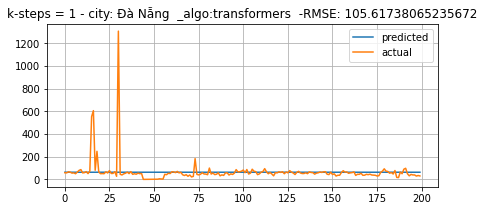

City: Đà Nẵng  _algo:transformers  -RMSE: 105.75135624255692


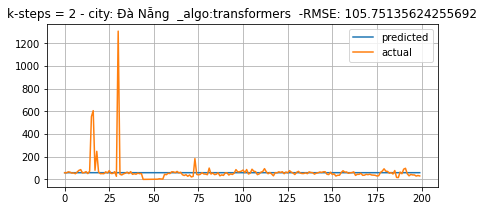

City: Đà Nẵng  _algo:transformers  -RMSE: 105.90128933449935


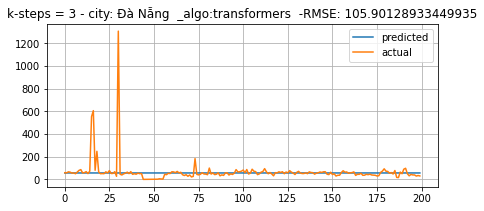

lookback 3


<ipython-input-19-76df619bec93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-76df619bec93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d3ac46aae96e>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/390 - train_loss: 0.8544 - test_loss: 0.702623
Epoch: 97/390 - train_loss: 0.1206 - test_loss: 0.059207
Epoch: 194/390 - train_loss: 0.1213 - test_loss: 0.056092
Epoch: 291/390 - train_loss: 0.1194 - test_loss: 0.060295
Epoch: 388/390 - train_loss: 0.1199 - test_loss: 0.058927
Epoch: 389/390 - train_loss: 0.1197 - test_loss: 0.054157
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 20.676034080007728


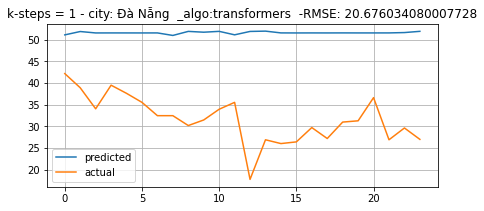

City: Đà Nẵng  _algo:transformers  -RMSE: 19.495719361869195


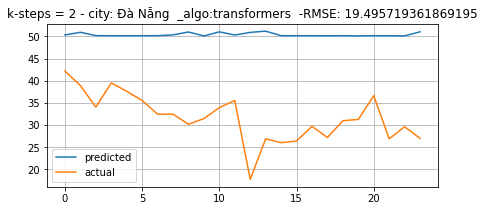

City: Đà Nẵng  _algo:transformers  -RMSE: 23.464698123868278


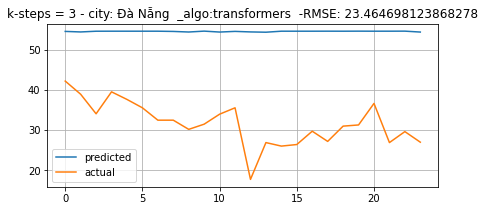

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -RMSE: 106.39974230954995


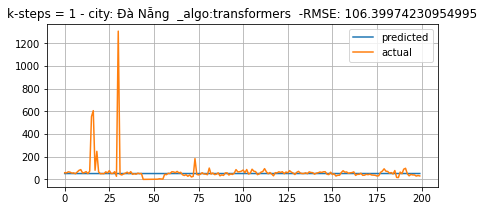

City: Đà Nẵng  _algo:transformers  -RMSE: 106.54372318690055


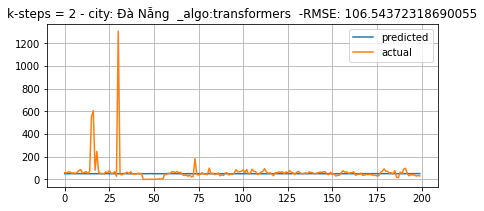

City: Đà Nẵng  _algo:transformers  -RMSE: 106.10512256525847


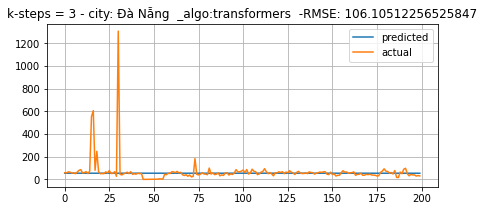

kết thúc train trong: 10
danh sách error city: 
{}


<ipython-input-19-76df619bec93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-76df619bec93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d3ac46aae96e>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

In [21]:
dt_started = datetime.now()
################################################
## Main run all city for Transformer
################################################
n_LoopEachExpRun = 5
expRuntime = 0 # basicly just increase each time

cities = ['Đà Nẵng']

# 'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định', 'Đà Nẵng'
# 'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',

# 'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
# 'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',

# 'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng', 'Đắk Nông'
# 'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',

# 'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi', 'Đắk Lắk'
# 'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',

# 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh', 'Đồng Tháp'
# 'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',


l_errCity = {}
# Với mỗi thành phố ta sẽ chạy n_LoopEachExpRun lần ứng với từng giải thuật.
# Nếu chỉ chạy 1 lần thì để n_LoopEachExpRun = 0

for city in cities:
  try:
    
    total_result = pd.DataFrame() # final result cho mỗi thành phố of all runninng time
    total_metrix_result = pd.DataFrame() # final metrix result cho mỗi thành phố of all runninng time
    mix_train_test_result_tf=pd.DataFrame()

    for interation in range(n_LoopEachExpRun):
      
      # Pre-process data
      specific_data = get_city_data(fix_text(city))
      specific_data = impute_missing_value(specific_data)
      specific_data = convert_to_stationary(specific_data)
      specific_data.dropna(inplace=True)
      
      # Get right optimize parame
      n_layers, hidden_size, _, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name(algo='transformer', city=city)
      
      train, test = split_data(specific_data,lookback_window)

      # Fit data scaler to training data
      full_scaler = MinMaxScaler().fit(train)
      y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

      # Scale train and test data
      train = full_scaler.transform(train)
      test = full_scaler.transform(test)

      # Get data to run model
      important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, specific_data)

      # Overwrite parameters for province-specific diarrhoea prediction
      args.look_back = lookback_window
      print(city)
      trainer = Trainer(
                      model_type='transformers',
                      city = city, 
                      learning_rate=learning_rate,
                      important_features=important_features,
                      train_loader=train_loader,
                      test_tensor=test_tensor,
                      n_layers=n_layers,
                      hidden_size=hidden_size,
                      dropout=dropout)

      # Train model with province-specific epochs
      trainer.train(epochs=epoch)

      print("Evaluate on test set: ")
      y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= True, scaled=True, city=city, y_scaler= y_scaler)

      print("Evaluate on train set: ")
      y_true_train, y_pred_train,  _, _, _, = trainer.evaluate_model(np_data=train, plot=True, scaled=True, city=city, y_scaler= y_scaler)

      # Lưu tất cả kết quả predicted train và predicted test
      mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer', specific_data, y_pred_test, 
                                                                              y_pred_train,lookback_window,interation, rmse_list[0],mae_list[0],mape_list[0])) 


      transformer_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,
                                'Observed': y_true_test[0], 
                                '1-month': y_pred_test[0], 
                                '2-months': y_pred_test[1],
                                '3-months': y_pred_test[2],
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': mape_list[2]})

      transformer_metrix_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,                          
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0
      
      total_result = total_result.append(pd.DataFrame(transformer_reslt))
      total_metrix_result = total_metrix_result.append(pd.DataFrame(transformer_metrix_reslt))
    
    # Lưu xuống file excel ứng với từng thành phố
    total_result.to_excel(path+'/diarrhoea_transformer_'+city+'_'+str(expRuntime)+'.xlsx')  
    total_metrix_result.to_excel(path_metrix+'/diarrhoea_metrix_transformer_'+city+'_'+str(expRuntime)+'.xlsx')
    
    # Lưu xuống mix predicted train và test data ứng với từng thành phố/ từng giải thuật
    save_results(mix_train_test_result_tf,'tf', city)
  except Exception as e:
    l_errCity[city] = e
    break

dt_ended = datetime.now()
print('kết thúc train trong:', round((dt_ended - dt_started).total_seconds()/60))
print ('danh sách error city: ')
print(l_errCity)

In [22]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        print(e)

send_to_telegram("TEST\nList city:\n" + ',\n'.join(str(city) for city in cities) + "\nalgo: transformer ntry = 10" )

{"ok":true,"result":{"message_id":201,"sender_chat":{"id":-1001712314864,"title":"PTN_Announcement","username":"ptn_announcement","type":"channel"},"chat":{"id":-1001712314864,"title":"PTN_Announcement","username":"ptn_announcement","type":"channel"},"date":1675145922,"text":"TEST\nList city:\n\u0110\u00e0 N\u1eb5ng\nalgo: transformer ntry = 10"}}
